In [1]:
import os
from matplotlib import rc
from matplotlib import font_manager

rc('font', family='Heiti TC')
os.chdir('/Users/villager/Moo/notebook/data')

/var/folders/qw/phdvn0910l7ccdzt4z3cxz440000gn/T/ipykernel_76545/996753936.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualize=(1+simpleret).cumprod()[-1]**(245/311)-1


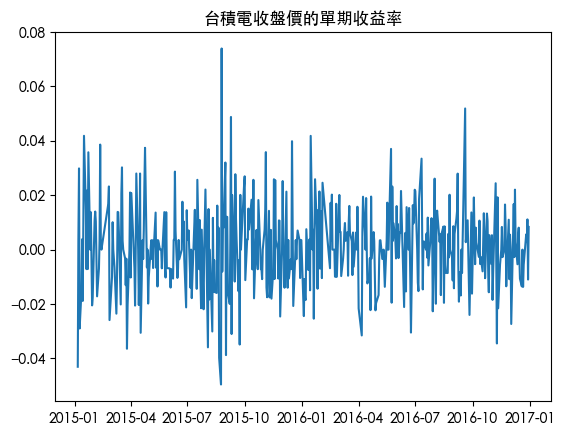

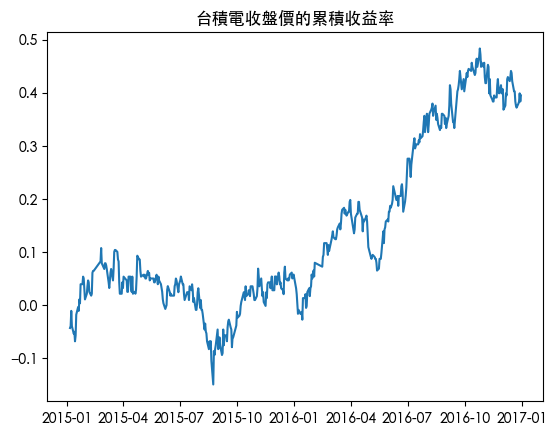

-0.19783439490445842

In [2]:
# ch19
import pandas as pd
import ffn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime

# 抓取台積電收盤價資量
stock=pd.read_csv('2330.csv',index_col='Date',sep='\t')
stock.head()

# 轉化成代日期的格式 時間序列
close=stock.Close 
close.index=pd.to_datetime(close.index)

# 將收盤價滯後一期
lagclose=close.shift(1)
lagclose.head()

# 計算單期簡單收益率
simpleret=(close-lagclose)/lagclose
simpleret.name='simpleret'
simpleret.head()

# 計算2期簡單收益率
simpleret2=(close-close.shift(2))/close.shift(2)
simpleret2.name='simpleret2'
simpleret2.head()


# ffn簡單收益率
ffnSimpleret=ffn.to_returns(close)
ffnSimpleret.name='ffnSimpleret'
ffnSimpleret.head()

# 假設一年有245交易日
annualize=(1+simpleret).cumprod()[-1]**(245/311)-1
annualize

def annualize(returns,period):
    if period=='day':
        return((1+returns).cumprod()[-1]**(245/len(returns))-1)
    elif period=='month':
        return((1+returns).cumprod()[-1]**(12/len(returns))-1)
    elif period=='quarter':
        return((1+returns).cumprod()[-1]**(4/len(returns))-1)
    elif period=='year':
        return((1+returns).cumprod()[-1]**(1/len(returns))-1)
    else:
        raise Exception("Wrong period")

# 連續複利
comporet=np.log(close/lagclose)
comporet.name='comporet'
comporet.head()
# ffn連續複利
ffnComporet=ffn.to_log_returns(close)
ffnComporet.head()
# 多期連續複利
comporet2=np.log(close/close.shift(2))
comporet2.name='comporet2'
comporet2.head()

# 2期連續複利收益率
comporet2=comporet2.dropna()
comporet2.head()
# 前一天和當天的單期複利收益率之和
sumcomporet=comporet+comporet.shift(1)
sumcomporet.head()

# 繪製收益圖
plt.plot(simpleret)
plt.title('台積電收盤價的單期收益率')
plt.show()
# 根據單期收益率來計算累積收益率
cumRet=(1+simpleret).cumprod()-1
plt.plot(cumRet)
plt.title('台積電收盤價的累積收益率')
plt.show()



# 資料日期2015/01/01到2016/12/30
TSMC=pd.read_csv('2330.csv',sep='\t',index_col='Date')
TSMC.index=pd.to_datetime(TSMC.index)

FoxConn=pd.read_csv('2317.csv',sep='\t',index_col='Date')
FoxConn.index=pd.to_datetime(FoxConn.index)

retTSMC=ffn.to_returns(TSMC.Close).dropna()
retFoxConn=ffn.to_returns(FoxConn.Close).dropna()

retTSMC.std()
retFoxConn.std()

# downside risk
# 用收益率均值作為MARR(最低可接受收益率)
def cal_half_dev(returns):
    mu=returns.mean()
    temp=returns[returns<mu]
    half_deviation=(sum((mu-temp)**2)/len(returns))**0.5
    return(half_deviation)

cal_half_dev(retTSMC)
cal_half_dev(retFoxConn)

# 歷史模擬法 計算VaR(風險價值) 有 x % 可能下跌多少
retTSMC.quantile(0.05)
retFoxConn.quantile(0.05)

# 共變異數矩陣法
norm.ppf(0.05,retTSMC.mean(),retTSMC.std())
norm.ppf(0.05,retFoxConn.mean(),retFoxConn.std())

# 計算ES(預期損失) 最壞 x % 損失的平均值
retTSMC[retTSMC<=retTSMC.quantile(0.05)].mean()
retFoxConn[retFoxConn<=retFoxConn.quantile(0.05)].mean()

# MDD 最大虧損
r=pd.Series([0,0.1,-0.1,-0.01,0.01,0.02],index=[datetime.date(2015,7,x) for x in range(3,9)])
r
value=(1+r).cumprod()
value
D=value.cummax()-value
D
d=D/(D+value)
d
MDD=D.max()
MDD
mdd=d.max()
mdd
# ffn MDD
ffn.calc_max_drawdown(value)
ffn.calc_max_drawdown((1+retTSMC).cumprod())
ffn.calc_max_drawdown((1+retFoxConn).cumprod())

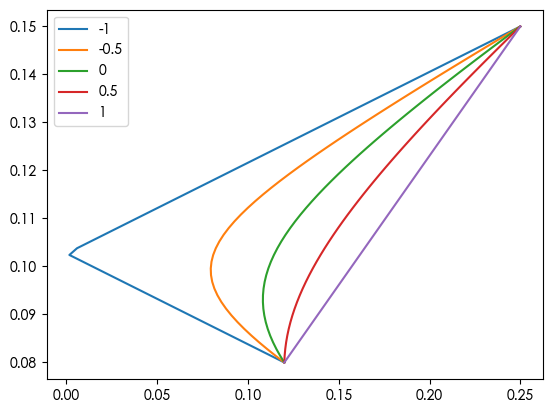

In [3]:
# ch20
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
#import portfolioopt as pfopt
from pypfopt import EfficientFrontier
'''
The portfolioopt package has not been updated for 5 years.
We replace the portfolioopt package with the PyPortfolioOpt package.
https://github.com/robertmartin8/PyPortfolioOpt
https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html
'''
from scipy import linalg

def cal_mean(frac):
    return(0.08*frac+0.15*(1-frac))

mean=list(map(cal_mean,[x/50 for x in range(51)]))
sd_mat=np.array([list(map(lambda x: math.sqrt((x**2)*0.12**2+
((1-x)**2)*0.25**2+2*x*(1-x)*(-1.5+i*0.5)*0.12*0.25),[x/50 for x in range(51)])
) for i in range(1,6)])
# 不同相關係數均值標準差關係圖
#[expression for variable in sequence] list comprehension
plt.plot(sd_mat[0,:],mean,label='-1')
plt.plot(sd_mat[1,:],mean,label='-0.5')
plt.plot(sd_mat[2,:],mean,label='0')
plt.plot(sd_mat[3,:],mean,label='0.5')
plt.plot(sd_mat[4,:],mean,label='1')
plt.legend(loc='upper left')


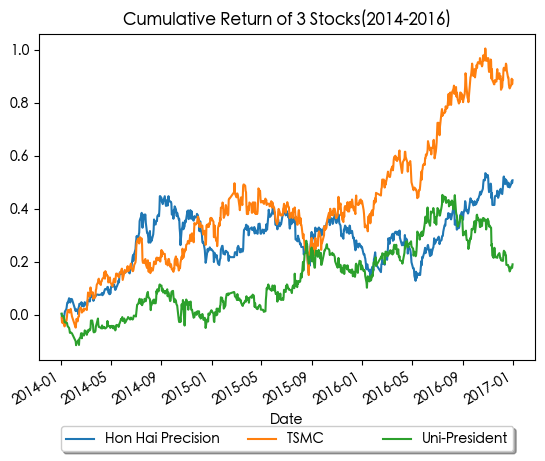

In [4]:
# 讀取資料
retData = pd.read_csv('retdata.csv',
                      sep='\t',index_col='Date')
retData.index = pd.to_datetime(retData.index)
retData = retData*0.01
retData.head()


# 檢視各股的累積收億率
cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 3 Stocks(2014-2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5, fancybox=True, shadow=True)
# 檢視各股回報相關性          
retData=retData.dropna()
retData.corr()

train_set=retData['2014-01-01':'2015-12-31']
test_set=retData['2016-01-01':'2016-12-31']

# 求共變異數矩陣
cov_mat =train_set.cov()
# 求收益平均值
avg_rets = train_set.mean()


OrderedDict([('Hon Hai Precision', 0.3660365764953863),
             ('TSMC         ', 0.5023345537695135),
             ('Uni-President', 0.1316288697351002)])

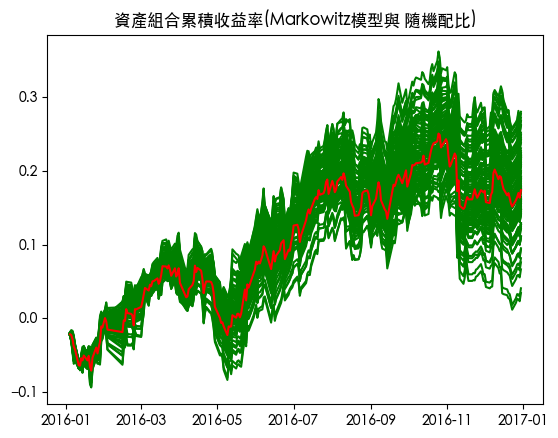

In [5]:
#only long 
# 設定目標收益率
target_ret = 0.0006


#weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret,
#  allow_short=False)
#weights


ef = EfficientFrontier(avg_rets, cov_mat)
weights=ef.efficient_return(target_return=target_ret)
weights

weights=pd.DataFrame(weights.values(),index=weights.keys())                     
# 測試集中計算 markowitz 資產配置後 資產組合的累積收益率
test_return=np.dot(test_set,
                   weights)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns = ['markowitz_portfolio']
test_cum_return.head()
# 隨機產生0到1的二維array 結構為 30 rows 3 columns
sim_weight=np.random.uniform(0,1,(100,3))
# 將產生的數據進行normalize 使得每一個row的元素值總和為1
sim_weight_normalized =np.apply_along_axis(lambda x: x/sum(x),1,sim_weight)
# 對每一個資產配比 計算資產組合收益率
sim_return=np.dot(test_set,np.matrix(sim_weight_normalized).T)
sim_return=pd.DataFrame(sim_return,index=test_set.index)
# 對每一個資產配比 計算資產組合的累積收益率
sim_cum_return=(1+sim_return).cumprod()-1
# sim_cum_return.shape(244, 30)
# sim_cum_return.head(1)

# 繪製累積收益圖
plt.plot(sim_cum_return.index,sim_cum_return,color='green')
plt.plot(test_cum_return.index,test_cum_return,color='red')
plt.title('資產組合累積收益率(Markowitz模型與 隨機配比)')

# black-litterman 模型
def blacklitterman(returns,tau, P, Q):
  mu=returns.mean()
  sigma=returns.cov()
  pi1=mu
  ts = tau * sigma
  Omega = np.dot(np.dot(P,ts),P.T) * np.eye(Q.shape[0])
  middle = linalg.inv(np.dot(np.dot(P,ts),P.T) + Omega)  
  er = np.expand_dims(pi1,axis=0).T + np.dot(np.dot(np.dot(ts,P.T),middle),
                      (Q - np.expand_dims(np.dot(P,pi1.T),axis=1)))
  posteriorSigma = sigma + ts - np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
  return [er, posteriorSigma]

# 構造投資人的個人觀點
# 建構資產選曲矩陣p  
pick1=np.array([1,1,0])
q1=np.array([0.0009])
pick2=np.array([1,0,-1])
q2=np.array([0.0003])
P=np.array([pick1,pick2])
Q=np.array([q1,q2])
P
Q
# 修正後驗收益
res=blacklitterman(retData,0.1, P, Q)
p_mean=pd.DataFrame(res[0],index=retData.columns,columns=['posterior_mean'])
p_mean
p_cov=res[1]
p_cov

# 設定目標收益率為0.006 只能做多
target_ret2 = 0.0006
cov_mat2 = res[1]
avg_rets2 = pd.Series(res[0][:,0],index=retData.columns)

#weights2 = pfopt.markowitz_portfolio(cov_mat2, avg_rets2, target_ret2,
#  allow_short=False)
#weights2


ef = EfficientFrontier(avg_rets2, cov_mat2)
weights2=ef.efficient_return(target_return=target_ret2)
weights2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     18.56
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           2.39e-05
Time:                        18:31:38   Log-Likelihood:                 797.60
No. Observations:                 243   AIC:                            -1591.
Df Residuals:                     241   BIC:                            -1584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.272      0.786      -0.001       0.001
mktret         0.3093      0.072      4.309      0.000       0.168       0.451
==============================================================================
Omnibus:                       49.681   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.021
Skew:                           0.606   Prob(JB):                     1.93e-65
Kurtosis:                       8.288   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

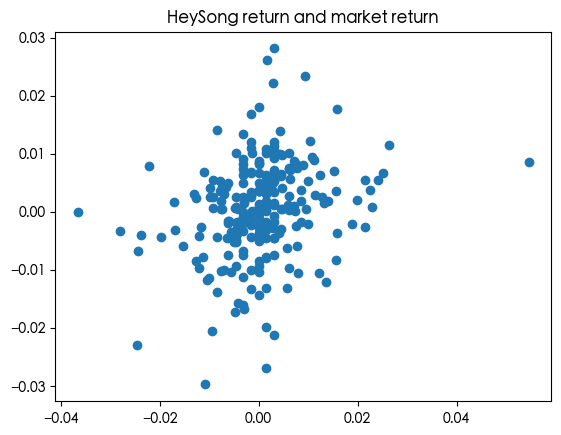

In [6]:
# ch21
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 獲取指數資料
indexData=pd.read_csv('index.csv',sep='\t')
np.unique(indexData.CoName)
mktData=indexData[indexData.CoName=='TSE Taiex    ']
mktData.head()

mktret=pd.Series(mktData.ROI.values,index=pd.to_datetime(mktData.Date))
mktret.name='mktret'
mktret.head()


# 獲取黑松股票收益率資料
HeySong=pd.read_csv('1234.csv',sep='\t')
HeySong.index=pd.to_datetime(HeySong.Date)
HeySong.head()
HeySongret=HeySong.ROI
HeySongret.name='returns'
# 將黑松股票和市場指數收益率合併在一起 將沒有交易的資料移除
retData=pd.concat([HeySongret,mktret],axis=1).dropna()
# ROI的單位是% 把數據乘 0.01 轉成實際收益率 
retData = retData.astype(float)*0.01
retData.head()
# 計算無風險收益率
rf=1.0038**(1/360)-1
rf
# 計算股票超額收益率和市場風險溢酬
Excess_ret=retData['2016-01-01':'2016-12-31']-rf
Excess_ret.tail()

# 畫出散佈圖
plt.scatter(Excess_ret.values[:,0],Excess_ret.values[:,1])
plt.title('HeySong return and market return')
# 擬合CAPM模型 用statsmodels OLS()做
model=sm.OLS(Excess_ret.returns[1:],sm.add_constant(Excess_ret.mktret[1:]))
result=model.fit()
# Ri - Rf = alpha + beta * (Rm - Rf) + e
result.summary()


In [7]:
# ch22
import pandas as pd
import statsmodels.api as sm

# 讀取資料
stock=pd.read_csv('retdata.csv',sep='\t')
stock.head(n=3)
stock.index = pd.to_datetime(stock.Date)
UniPresident = stock.iloc[:,3]
UniPresident.head(n=3)

# 獲取三因子資料
factors=pd.read_csv('factors.csv', sep=',')
factors.head(n=3)
factors.index =pd.to_datetime(factors['YY/MM/DD']) 
factors.columns
# 將年度無風險利率轉化成日度無風險收益率
factors['Risk-free Interest Rate']=(factors['Risk-free Interest Rate']**(1/360)-1)*100
factors.head(n=3)

# 合併個股收益率數據與因子收益率數據 計算統一股票超額收益率
data=pd.concat([UniPresident,factors.iloc[:,1:]],axis=1).dropna()
data.tail(n=3)

data['Uni-President'] = data['Uni-President'] - data['Risk-free Interest Rate']
print(data['Uni-President'][0:5])
print(sm.add_constant(data.iloc[:,:])[0:5])
# 建立多元回歸模型
regThrFac=sm.OLS((data['Uni-President']),sm.add_constant((data.iloc[:,3:-1])))
result=regThrFac.fit()
result.summary()

result.params

2014-01-02    0.474275
2014-01-03   -1.010325
2014-01-06   -0.084425
2014-01-07   -0.271325
2014-01-08   -0.458925
Name: Uni-President, dtype: float64
            Uni-President                         CoName    YY/MM/DD  \
2014-01-02       0.474275  TSEC+GreTai Non-Banking index  2014/01/02   
2014-01-03      -1.010325  TSEC+GreTai Non-Banking index  2014/01/03   
2014-01-06      -0.084425  TSEC+GreTai Non-Banking index  2014/01/06   
2014-01-07      -0.271325  TSEC+GreTai Non-Banking index  2014/01/07   
2014-01-08      -0.458925  TSEC+GreTai Non-Banking index  2014/01/08   

            Market Risk Premium  Size Factor (3 Factor)  \
2014-01-02               0.0145                  0.7197   
2014-01-03              -0.5858                  0.6868   
2014-01-06              -0.4534                  0.5783   
2014-01-07               0.1950                  0.4554   
2014-01-08               0.6204                 -0.0295   

            Book to Market Factor  Risk-free Interest Rate  


const                    -0.117379
Market Risk Premium       1.079372
Size Factor (3 Factor)   -0.056831
Book to Market Factor    -0.014195
dtype: float64

# Excercise

### 用Python計算收益率

* 讀取統一股票2014年交易資料
* 計算統一2014年的每個交易日的簡單收益率
* 計算統一2014年的每個交易日的複合收益率
* 計算統一2014年複合收益率
* 繪製統一2014年簡單收益率曲線
* 繪製統一2014年的累積收益率曲線

### 現在市場有四種資產A B C D 根據下列判斷寫出選取矩陣P 看法向量矩陣Q

* 資產A收益率為6%
* 資產B收益率比資產D低2%
* 資產C收益率比A低3%

### 假設上題中的資產A B C D分別為東元(1504) 中工(2515) 大魯閣(1432) 葡萄王(1707) 獲取這四支股票從2014年到2016年的股票資料並利用BL模型建構資產組合

### 獲取聯電(2303) 2016年的股價資料並建立CAPM模型 市場組合收益率為本章所使用的資料

### 獲取矽品(2325) 2015年的股價資料

* 建立CAPM模型
* 使用該模型估計矽品2016年1月份的預期收益率並與實際收益率進行比較

### 讀取problem21.txt 檔案中的個股收益率以及ThreeFactors.txt 檔案中的三因子資料 運用2016年數據 按照文中步驟建立三因子模型

### 讀取宏達電(2498) 的2014年資料以及三因子資料

* 利用2014年度的數據建立CAPM模型
* 利用2014年度的數據建立三因子模型
* 分別使用建構的CAPM模型和三因子模型估計宏達電2015年1月的收益率 比較兩者結果

### 檔案Bank.csv 中包含了金融類各支股票的2014年股價資料 讀取這些資料以及ThreeFactors.txt 檔案中的2014年三因子資料

* 對各支股票建立CAPM模型 並根據Alpha值選出三支股票
* 對各支股票建立三因子模型 並根據Alpha值選出三支股票
* 比較兩種模型選股的結果
